## Pre-Trained Models



In [45]:
from skimage.metrics import structural_similarity
import imageio as io
import matplotlib.pyplot as plt
import cv2

In [27]:
img1 = io.imread("/Users/meghna_mac2/PycharmProjects/WMCA/archive/socal2/socal_pics/35.jpg")
img2 = io.imread("/Users/meghna_mac2/PycharmProjects/WMCA/archive/socal2/socal_pics/38.jpg")
img3 = io.imread("/Users/meghna_mac2/PycharmProjects/WMCA/archive/socal2/socal_pics/13.jpg")

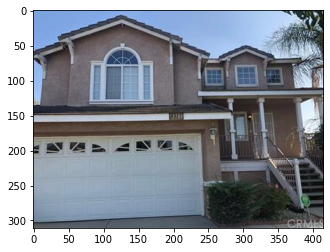

In [28]:
plt.imshow(img1)

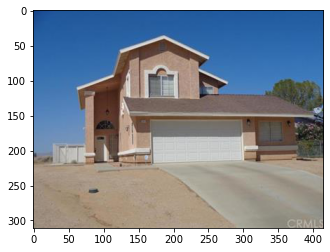

In [29]:
plt.imshow(img2)

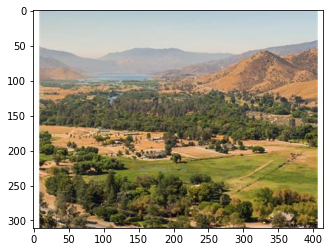

In [30]:
plt.imshow(img3)

## Structural Similarity

In [20]:
def orb_sim(img1, img2):
  # SIFT is no longer available in cv2 so using ORB
  orb = cv2.ORB_create()

  # detect keypoints and descriptors
  kp_a, desc_a = orb.detectAndCompute(img1, None)
  kp_b, desc_b = orb.detectAndCompute(img2, None)

  # define the bruteforce matcher object
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
  #perform matches. 
  matches = bf.match(desc_a, desc_b)
  #Look for similar regions with distance < 50. Goes from 0 to 100 so pick a number between.
  similar_regions = [i for i in matches if i.distance < 50]  
  if len(matches) == 0:
    return 0
  return len(similar_regions) / len(matches)

In [21]:
#Needs images to be same dimensions
def structural_sim(img1, img2):

  sim, diff = structural_similarity(img1, img2, full=True)
  return sim

In [33]:
orb_similarity = orb_sim(img1, img1)  #1.0 means identical. Lower = not similar

print("Similarity using ORB is: ", orb_similarity)

Similarity using ORB is:  1.0


In [26]:
orb_similarity = orb_sim(img1, img2)  #1.0 means identical. Lower = not similar

print("Similarity using ORB is: ", orb_similarity)

Similarity using ORB is:  0.12


In [31]:
orb_similarity = orb_sim(img2, img3)  #1.0 means identical. Lower = not similar

print("Similarity using ORB is: ", orb_similarity)

Similarity using ORB is:  0.025157232704402517


In [32]:
orb_similarity = orb_sim(img1, img3)  #1.0 means identical. Lower = not similar

print("Similarity using ORB is: ", orb_similarity)

Similarity using ORB is:  0.012345679012345678


## Cosine Distance

In [35]:
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
import numpy as np

In [36]:
model_url = "https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2"

IMAGE_SHAPE = (224, 224)

layer = hub.KerasLayer(model_url)
model = tf.keras.Sequential([layer])

2022-06-30 22:58:50.023446: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [37]:
def extract(file):
  file = Image.open(file).convert('L').resize(IMAGE_SHAPE)
  #display(file)

  file = np.stack((file,)*3, axis=-1)

  file = np.array(file)/255.0

  embedding = model.predict(file[np.newaxis, ...])
  #print(embedding)
  vgg16_feature_np = np.array(embedding)
  flattended_feature = vgg16_feature_np.flatten()

  #print(len(flattended_feature))
  #print(flattended_feature)
  #print('-----------')
  return flattended_feature

In [38]:
i1 = extract('/Users/meghna_mac2/PycharmProjects/WMCA/archive/socal2/socal_pics/35.jpg')
i2 = extract('/Users/meghna_mac2/PycharmProjects/WMCA/archive/socal2/socal_pics/38.jpg')
i3 = extract('/Users/meghna_mac2/PycharmProjects/WMCA/archive/socal2/socal_pics/13.jpg')

1/1 [==============================] - 0s 53ms/step


In [39]:
from scipy.spatial import distance

In [40]:
metric = 'cosine'

In [41]:
dc = distance.cdist([i1], [i1], metric)[0]
print(dc)
print("the distance between original and the original is {}".format(dc))

[0.]
the distance between original and the original is [0.]


In [42]:
dc = distance.cdist([i1], [i2], metric)[0]
print(dc)
print("the distance between original and the original is {}".format(dc))

[0.39260602]
the distance between original and the original is [0.39260602]


In [43]:
dc = distance.cdist([i1], [i3], metric)[0]
print(dc)
print("the distance between original and the original is {}".format(dc))

[0.74340577]
the distance between original and the original is [0.74340577]


In [44]:
dc = distance.cdist([i3], [i2], metric)[0]
print(dc)
print("the distance between original and the original is {}".format(dc))

[0.69079073]
the distance between original and the original is [0.69079073]
